In [1]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, ParameterGrid

In [2]:
parameters = {'kernel':['linear', 'rbf'],
              'C':[0.5, 1, 5, 10, 50],
              'epsilon':[0.1, 0.01, 0.001]}

In [3]:
def GridSearch(rf, X_train, X_test, y_train, y_test, grid, verbose=False, skip=False):
    best_score = 0
    par = ParameterGrid(grid)
    ln = len(par)
    i = 0
    for g in par:
        if skip and i == 46:
            continue
        if(verbose):
            print(f"Probando: {g}, {i} de {ln}")
        i+=1
        rf.set_params(**g)
        startTime = time.time()
        rf.fit(X_train, np.ravel(y_train))
        elapsedTime = time.time() - startTime
        score = rf.score(X_test, y_test)
        if(verbose):
            print(f"Tiempo de entrenamiento: {elapsedTime} s, score: {score}")
        # save if best
        if score > best_score:
            best_score = score
            best_grid = g
    print(f"Best Score: {best_score}")
    print(f"Best Parameters: {best_grid}")
    return best_grid

In [4]:
Year_to_separate = 2000
df = pd.read_parquet("dataset.parquet")
Y = df[['Municipal', 'Year']]
X = df[[x for x in df.columns if x not in ['Country', 'COU', 'Municipal', 'Household', 'Recovered', 'Recicled', 'Compost', 'Disposal']]]
X_train = X[X.Year < Year_to_separate].copy()
X_test = X[X.Year >= Year_to_separate].copy()
Y_train = Y[X.Year < Year_to_separate].copy()
Y_test = Y[X.Year >= Year_to_separate].copy()
#X_train = pd.read_parquet("Xtime/X_train.parquet")
#X_test = pd.read_parquet("Xtime/X_test.parquet")
#Y_train = pd.read_parquet("Ytime/Y_train.parquet")
#Y_test = pd.read_parquet("Ytime/Y_test.parquet")
X_train.drop(columns={'Year'}, inplace=True)
X_test.drop(columns={'Year'}, inplace=True)
scalerX = MinMaxScaler().fit(X_train)
X_train = pd.DataFrame(scalerX.transform(X_train))
X_test = pd.DataFrame(scalerX.transform(X_test))
scalerY = MinMaxScaler().fit(Y_train)
Y_train = pd.DataFrame(scalerY.transform(Y_train))
Y_test = pd.DataFrame(scalerY.transform(Y_test))
Y_train = Y_train[[Y_train.columns[0]]]
Y_test = Y_test[[Y_test.columns[0]]]

In [5]:
g = GridSearch(svm.SVR(), X_train, X_test, Y_train, Y_test, parameters, verbose=True)
clf1 = svm.SVR(**g).fit(X_train, np.ravel(Y_train))

Probando: {'C': 0.5, 'epsilon': 0.1, 'kernel': 'linear'}, 0 de 30
Tiempo de entrenamiento: 0.014339685440063477 s, score: 0.6388610300880531
Probando: {'C': 0.5, 'epsilon': 0.1, 'kernel': 'rbf'}, 1 de 30
Tiempo de entrenamiento: 0.0033736228942871094 s, score: 0.5218088718583496
Probando: {'C': 0.5, 'epsilon': 0.01, 'kernel': 'linear'}, 2 de 30
Tiempo de entrenamiento: 0.01934647560119629 s, score: 0.7718493296500194
Probando: {'C': 0.5, 'epsilon': 0.01, 'kernel': 'rbf'}, 3 de 30
Tiempo de entrenamiento: 0.010976314544677734 s, score: 0.644915091917142
Probando: {'C': 0.5, 'epsilon': 0.001, 'kernel': 'linear'}, 4 de 30
Tiempo de entrenamiento: 0.01936936378479004 s, score: 0.7559165235334611
Probando: {'C': 0.5, 'epsilon': 0.001, 'kernel': 'rbf'}, 5 de 30
Tiempo de entrenamiento: 0.019357681274414062 s, score: 0.6454989320695825
Probando: {'C': 1, 'epsilon': 0.1, 'kernel': 'linear'}, 6 de 30
Tiempo de entrenamiento: 0.013434410095214844 s, score: 0.6645959287585261
Probando: {'C': 1, '

In [6]:
df.COU.unique()

array(['AUS', 'AUT', 'BEL', 'CAN', 'CZE', 'DNK', 'FIN', 'FRA', 'DEU',
       'GRC', 'HUN', 'ISL', 'IRL', 'ITA', 'JPN', 'KOR', 'LUX', 'MEX',
       'NLD', 'NZL', 'NOR', 'POL', 'PRT', 'SVK', 'ESP', 'SWE', 'CHE',
       'TUR', 'GBR', 'USA', 'BRA', 'CHL', 'CHN', 'EST', 'IDN', 'ISR',
       'RUS', 'SVN', 'COL', 'LVA', 'CRI', 'IND', 'LTU'], dtype=object)

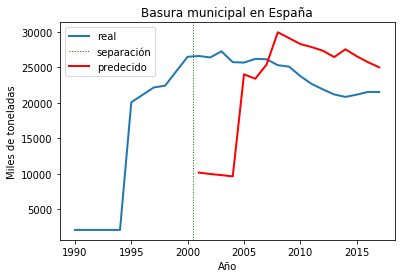

8.745088438366942


In [7]:
country = 'ESP'
esp = df[df.COU == country]
years = list(esp.Year)
mun = list(esp.Municipal)
predictions = clf1.predict(pd.DataFrame(scalerX.transform(df.loc[esp.index[Year_to_separate-2017::],:][[
       'Built', 'Below Secundary', 'Income Median',
       'Population', 'Over 65', 'Over 65 Percentage', 'Over 85',
       'Over 85 Percentage', 'Over 50', 'Over 50 Percentage', 'Under 20',
       'Under 20 Percentage', 'Income Per Capita', 'Tourism', 'Area',
       'Built Area']])))
predictions = [a[0] for a in scalerY.inverse_transform([[a,0] for a in predictions])]
plt.plot(years, mun, lw=2, label='real')
plt.axvline(x=Year_to_separate + 0.5, c='green', lw=1, ls=':', label='separación')
plt.plot([y for y in years if y > Year_to_separate], predictions, c='red', lw=2, label='predecido')
plt.title("Basura municipal en España")
plt.xlabel("Año")
plt.ylabel("Miles de toneladas")
plt.legend()
plt.show()
print(np.abs(((np.array(mun[-len(predictions):]) - np.array(predictions)))/np.array(predictions)).sum())
deu2000 = predictions

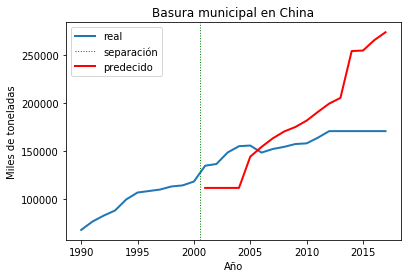

3.51496979782221


In [8]:
country = 'CHN'
esp = df[df.COU == country]
years = list(esp.Year)
mun = list(esp.Municipal)
predictions = clf1.predict(pd.DataFrame(scalerX.transform(df.loc[esp.index[Year_to_separate-2017::],:][[
       'Built', 'Below Secundary', 'Income Median',
       'Population', 'Over 65', 'Over 65 Percentage', 'Over 85',
       'Over 85 Percentage', 'Over 50', 'Over 50 Percentage', 'Under 20',
       'Under 20 Percentage', 'Income Per Capita', 'Tourism', 'Area',
       'Built Area']])))
predictions = [a[0] for a in scalerY.inverse_transform([[a,0] for a in predictions])]
plt.plot(years, mun, lw=2, label='real')
plt.axvline(x=Year_to_separate + 0.5, c='green', lw=1, ls=':', label='separación')
plt.plot([y for y in years if y > Year_to_separate], predictions, c='red', lw=2, label='predecido')
plt.title("Basura municipal en China")
plt.xlabel("Año")
plt.ylabel("Miles de toneladas")
plt.legend()
plt.show()
print(np.abs(((np.array(mun[-len(predictions):]) - np.array(predictions)))/np.array(predictions)).sum())
chn2000 = predictions

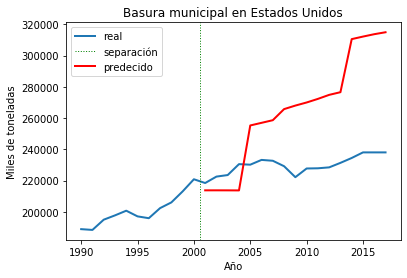

2.405912311368493


In [9]:
country = 'USA'
esp = df[df.COU == country]
years = list(esp.Year)
mun = list(esp.Municipal)
predictions = clf1.predict(pd.DataFrame(scalerX.transform(df.loc[esp.index[Year_to_separate-2017::],:][[
       'Built', 'Below Secundary', 'Income Median',
       'Population', 'Over 65', 'Over 65 Percentage', 'Over 85',
       'Over 85 Percentage', 'Over 50', 'Over 50 Percentage', 'Under 20',
       'Under 20 Percentage', 'Income Per Capita', 'Tourism', 'Area',
       'Built Area']])))
predictions = [a[0] for a in scalerY.inverse_transform([[a,0] for a in predictions])]
plt.plot(years, mun, lw=2, label='real')
plt.axvline(x=Year_to_separate + 0.5, c='green', lw=1, ls=':', label='separación')
plt.plot([y for y in years if y > Year_to_separate], predictions, c='red', lw=2, label='predecido')
plt.title("Basura municipal en Estados Unidos")
plt.xlabel("Año")
plt.ylabel("Miles de toneladas")
plt.legend()
plt.show()
print(np.abs(((np.array(mun[-len(predictions):]) - np.array(predictions)))/np.array(predictions)).sum())
usa2000 = predictions

In [10]:
Year_to_separate = 2005
df = pd.read_parquet("dataset.parquet")
Y = df[['Municipal', 'Year']]
X = df[[x for x in df.columns if x not in ['Country', 'COU', 'Municipal', 'Household', 'Recovered', 'Recicled', 'Compost', 'Disposal']]]
X_train = X[X.Year < Year_to_separate].copy()
X_test = X[X.Year >= Year_to_separate].copy()
Y_train = Y[X.Year < Year_to_separate].copy()
Y_test = Y[X.Year >= Year_to_separate].copy()
#X_train = pd.read_parquet("Xtime/X_train.parquet")
#X_test = pd.read_parquet("Xtime/X_test.parquet")
#Y_train = pd.read_parquet("Ytime/Y_train.parquet")
#Y_test = pd.read_parquet("Ytime/Y_test.parquet")
X_train.drop(columns={'Year'}, inplace=True)
X_test.drop(columns={'Year'}, inplace=True)
#scalerX = MinMaxScaler().fit(X_train)
X_train = pd.DataFrame(scalerX.transform(X_train))
X_test = pd.DataFrame(scalerX.transform(X_test))
#scalerY = MinMaxScaler().fit(Y_train)
Y_train = pd.DataFrame(scalerY.transform(Y_train))
Y_test = pd.DataFrame(scalerY.transform(Y_test))
Y_train = Y_train[[Y_train.columns[0]]]
Y_test = Y_test[[Y_test.columns[0]]]

In [11]:
g = GridSearch(svm.SVR(), X_train, X_test, Y_train, Y_test, parameters, verbose=True)
clf1 = svm.SVR(**g).fit(X_train, np.ravel(Y_train))

Probando: {'C': 0.5, 'epsilon': 0.1, 'kernel': 'linear'}, 0 de 30
Tiempo de entrenamiento: 0.018497943878173828 s, score: 0.7947567937671441
Probando: {'C': 0.5, 'epsilon': 0.1, 'kernel': 'rbf'}, 1 de 30
Tiempo de entrenamiento: 0.0064678192138671875 s, score: 0.696405369937926
Probando: {'C': 0.5, 'epsilon': 0.01, 'kernel': 'linear'}, 2 de 30
Tiempo de entrenamiento: 0.04492664337158203 s, score: 0.8844386776599181
Probando: {'C': 0.5, 'epsilon': 0.01, 'kernel': 'rbf'}, 3 de 30
Tiempo de entrenamiento: 0.02389049530029297 s, score: 0.7808981895113762
Probando: {'C': 0.5, 'epsilon': 0.001, 'kernel': 'linear'}, 4 de 30
Tiempo de entrenamiento: 0.05318307876586914 s, score: 0.8951356965292552
Probando: {'C': 0.5, 'epsilon': 0.001, 'kernel': 'rbf'}, 5 de 30
Tiempo de entrenamiento: 0.04560971260070801 s, score: 0.7899925216444279
Probando: {'C': 1, 'epsilon': 0.1, 'kernel': 'linear'}, 6 de 30
Tiempo de entrenamiento: 0.023178815841674805 s, score: 0.7270618641621462
Probando: {'C': 1, 'ep

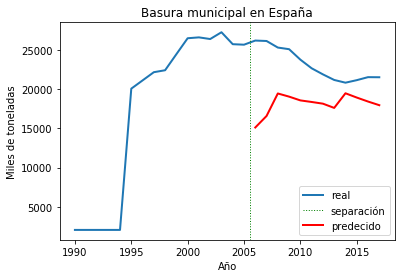

3.403444196042127


In [12]:
country = 'ESP'
esp = df[df.COU == country]
years = list(esp.Year)
mun = list(esp.Municipal)
predictions = clf1.predict(pd.DataFrame(scalerX.transform(df.loc[esp.index[Year_to_separate-2017::],:][[
       'Built', 'Below Secundary', 'Income Median',
       'Population', 'Over 65', 'Over 65 Percentage', 'Over 85',
       'Over 85 Percentage', 'Over 50', 'Over 50 Percentage', 'Under 20',
       'Under 20 Percentage', 'Income Per Capita', 'Tourism', 'Area',
       'Built Area']])))
predictions = [a[0] for a in scalerY.inverse_transform([[a,0] for a in predictions])]
plt.plot(years, mun, lw=2, label='real')
plt.axvline(x=Year_to_separate + 0.5, c='green', lw=1, ls=':', label='separación')
plt.plot([y for y in years if y > Year_to_separate], predictions, c='red', lw=2, label='predecido')
plt.title("Basura municipal en España")
plt.xlabel("Año")
plt.ylabel("Miles de toneladas")
plt.legend()
plt.show()
print(np.abs(((np.array(mun[-len(predictions):]) - np.array(predictions)))/np.array(predictions)).sum())
deu2005 = predictions

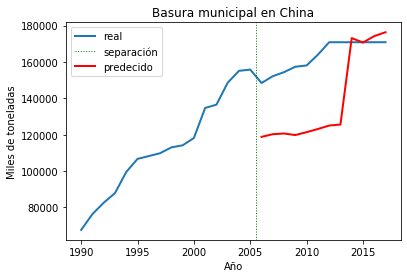

2.5321012014171984


In [13]:
country = 'CHN'
esp = df[df.COU == country]
years = list(esp.Year)
mun = list(esp.Municipal)
predictions = clf1.predict(pd.DataFrame(scalerX.transform(df.loc[esp.index[Year_to_separate-2017::],:][[
       'Built', 'Below Secundary', 'Income Median',
       'Population', 'Over 65', 'Over 65 Percentage', 'Over 85',
       'Over 85 Percentage', 'Over 50', 'Over 50 Percentage', 'Under 20',
       'Under 20 Percentage', 'Income Per Capita', 'Tourism', 'Area',
       'Built Area']])))
predictions = [a[0] for a in scalerY.inverse_transform([[a,0] for a in predictions])]
plt.plot(years, mun, lw=2, label='real')
plt.axvline(x=Year_to_separate + 0.5, c='green', lw=1, ls=':', label='separación')
plt.plot([y for y in years if y > Year_to_separate], predictions, c='red', lw=2, label='predecido')
plt.title("Basura municipal en China")
plt.xlabel("Año")
plt.ylabel("Miles de toneladas")
plt.legend()
plt.show()
print(np.abs(((np.array(mun[-len(predictions):]) - np.array(predictions)))/np.array(predictions)).sum())
chn2005 = predictions

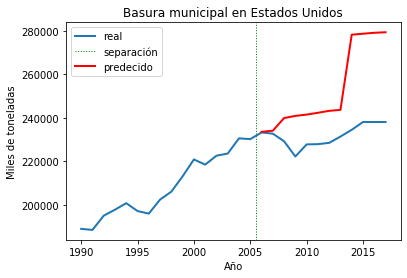

0.9536294678926005


In [14]:
country = 'USA'
esp = df[df.COU == country]
years = list(esp.Year)
mun = list(esp.Municipal)
predictions = clf1.predict(pd.DataFrame(scalerX.transform(df.loc[esp.index[Year_to_separate-2017::],:][[
       'Built', 'Below Secundary', 'Income Median',
       'Population', 'Over 65', 'Over 65 Percentage', 'Over 85',
       'Over 85 Percentage', 'Over 50', 'Over 50 Percentage', 'Under 20',
       'Under 20 Percentage', 'Income Per Capita', 'Tourism', 'Area',
       'Built Area']])))
predictions = [a[0] for a in scalerY.inverse_transform([[a,0] for a in predictions])]
plt.plot(years, mun, lw=2, label='real')
plt.axvline(x=Year_to_separate + 0.5, c='green', lw=1, ls=':', label='separación')
plt.plot([y for y in years if y > Year_to_separate], predictions, c='red', lw=2, label='predecido')
plt.title("Basura municipal en Estados Unidos")
plt.xlabel("Año")
plt.ylabel("Miles de toneladas")
plt.legend()
plt.show()
print(np.abs(((np.array(mun[-len(predictions):]) - np.array(predictions)))/np.array(predictions)).sum())
usa2005 = predictions

In [15]:
Year_to_separate = 2010
df = pd.read_parquet("dataset.parquet")
Y = df[['Municipal', 'Year']]
X = df[[x for x in df.columns if x not in ['Country', 'COU', 'Municipal', 'Household', 'Recovered', 'Recicled', 'Compost', 'Disposal']]]
X_train = X[X.Year < Year_to_separate].copy()
X_test = X[X.Year >= Year_to_separate].copy()
Y_train = Y[X.Year < Year_to_separate].copy()
Y_test = Y[X.Year >= Year_to_separate].copy()
#X_train = pd.read_parquet("Xtime/X_train.parquet")
#X_test = pd.read_parquet("Xtime/X_test.parquet")
#Y_train = pd.read_parquet("Ytime/Y_train.parquet")
#Y_test = pd.read_parquet("Ytime/Y_test.parquet")
X_train.drop(columns={'Year'}, inplace=True)
X_test.drop(columns={'Year'}, inplace=True)
#scalerX = MinMaxScaler().fit(X_train)
X_train = pd.DataFrame(scalerX.transform(X_train))
X_test = pd.DataFrame(scalerX.transform(X_test))
#scalerY = MinMaxScaler().fit(Y_train)
Y_train = pd.DataFrame(scalerY.transform(Y_train))
Y_test = pd.DataFrame(scalerY.transform(Y_test))
Y_train = Y_train[[Y_train.columns[0]]]
Y_test = Y_test[[Y_test.columns[0]]]

In [16]:
g = GridSearch(svm.SVR(), X_train, X_test, Y_train, Y_test, parameters, verbose=True)
clf1 = svm.SVR(**g).fit(X_train, np.ravel(Y_train))

Probando: {'C': 0.5, 'epsilon': 0.1, 'kernel': 'linear'}, 0 de 30
Tiempo de entrenamiento: 0.022049665451049805 s, score: 0.8794700837016414
Probando: {'C': 0.5, 'epsilon': 0.1, 'kernel': 'rbf'}, 1 de 30
Tiempo de entrenamiento: 0.008636474609375 s, score: 0.8343053432923109
Probando: {'C': 0.5, 'epsilon': 0.01, 'kernel': 'linear'}, 2 de 30
Tiempo de entrenamiento: 0.07176899909973145 s, score: 0.9216230791320466
Probando: {'C': 0.5, 'epsilon': 0.01, 'kernel': 'rbf'}, 3 de 30
Tiempo de entrenamiento: 0.048467397689819336 s, score: 0.942654396638087
Probando: {'C': 0.5, 'epsilon': 0.001, 'kernel': 'linear'}, 4 de 30
Tiempo de entrenamiento: 0.10145688056945801 s, score: 0.9204501167071995
Probando: {'C': 0.5, 'epsilon': 0.001, 'kernel': 'rbf'}, 5 de 30
Tiempo de entrenamiento: 0.08163714408874512 s, score: 0.9391235166189945
Probando: {'C': 1, 'epsilon': 0.1, 'kernel': 'linear'}, 6 de 30
Tiempo de entrenamiento: 0.02942967414855957 s, score: 0.8218717670110688
Probando: {'C': 1, 'epsilo

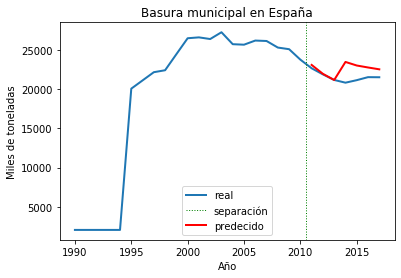

0.3148891583475862


In [17]:
country = 'ESP'
esp = df[df.COU == country]
years = list(esp.Year)
mun = list(esp.Municipal)
predictions = clf1.predict(pd.DataFrame(scalerX.transform(df.loc[esp.index[Year_to_separate-2017::],:][[
       'Built', 'Below Secundary', 'Income Median',
       'Population', 'Over 65', 'Over 65 Percentage', 'Over 85',
       'Over 85 Percentage', 'Over 50', 'Over 50 Percentage', 'Under 20',
       'Under 20 Percentage', 'Income Per Capita', 'Tourism', 'Area',
       'Built Area']])))
predictions = [a[0] for a in scalerY.inverse_transform([[a,0] for a in predictions])]
plt.plot(years, mun, lw=2, label='real')
plt.axvline(x=Year_to_separate + 0.5, c='green', lw=1, ls=':', label='separación')
plt.plot([y for y in years if y > Year_to_separate], predictions, c='red', lw=2, label='predecido')
plt.title("Basura municipal en España")
plt.xlabel("Año")
plt.ylabel("Miles de toneladas")
plt.legend()
plt.show()
print(np.abs(((np.array(mun[-len(predictions):]) - np.array(predictions)))/np.array(predictions)).sum())
deu2010 = predictions

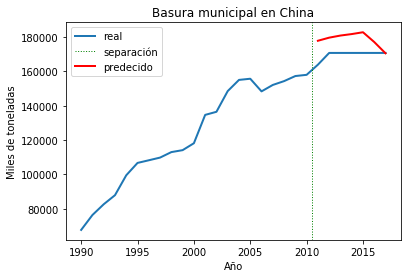

0.3474288148093213


In [18]:
country = 'CHN'
esp = df[df.COU == country]
years = list(esp.Year)
mun = list(esp.Municipal)
predictions = clf1.predict(pd.DataFrame(scalerX.transform(df.loc[esp.index[Year_to_separate-2017::],:][[
       'Built', 'Below Secundary', 'Income Median',
       'Population', 'Over 65', 'Over 65 Percentage', 'Over 85',
       'Over 85 Percentage', 'Over 50', 'Over 50 Percentage', 'Under 20',
       'Under 20 Percentage', 'Income Per Capita', 'Tourism', 'Area',
       'Built Area']])))
predictions = [a[0] for a in scalerY.inverse_transform([[a,0] for a in predictions])]
plt.plot(years, mun, lw=2, label='real')
plt.axvline(x=Year_to_separate + 0.5, c='green', lw=1, ls=':', label='separación')
plt.plot([y for y in years if y > Year_to_separate], predictions, c='red', lw=2, label='predecido')
plt.title("Basura municipal en China")
plt.xlabel("Año")
plt.ylabel("Miles de toneladas")
plt.legend()
plt.show()
print(np.abs(((np.array(mun[-len(predictions):]) - np.array(predictions)))/np.array(predictions)).sum())
chn2010 = predictions

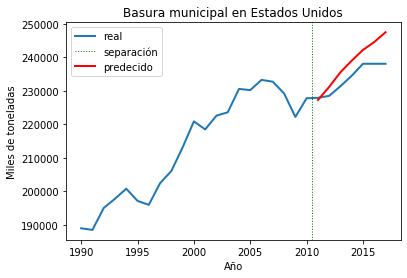

0.1325440619740717


In [19]:
country = 'USA'
esp = df[df.COU == country]
years = list(esp.Year)
mun = list(esp.Municipal)
predictions = clf1.predict(pd.DataFrame(scalerX.transform(df.loc[esp.index[Year_to_separate-2017::],:][[
       'Built', 'Below Secundary', 'Income Median',
       'Population', 'Over 65', 'Over 65 Percentage', 'Over 85',
       'Over 85 Percentage', 'Over 50', 'Over 50 Percentage', 'Under 20',
       'Under 20 Percentage', 'Income Per Capita', 'Tourism', 'Area',
       'Built Area']])))
predictions = [a[0] for a in scalerY.inverse_transform([[a,0] for a in predictions])]
plt.plot(years, mun, lw=2, label='real')
plt.axvline(x=Year_to_separate + 0.5, c='green', lw=1, ls=':', label='separación')
plt.plot([y for y in years if y > Year_to_separate], predictions, c='red', lw=2, label='predecido')
plt.title("Basura municipal en Estados Unidos")
plt.xlabel("Año")
plt.ylabel("Miles de toneladas")
plt.legend()
plt.show()
print(np.abs(((np.array(mun[-len(predictions):]) - np.array(predictions)))/np.array(predictions)).sum())
usa2010 = predictions

In [20]:
Year_to_separate = 2015
df = pd.read_parquet("dataset.parquet")
Y = df[['Municipal', 'Year']]
X = df[[x for x in df.columns if x not in ['Country', 'COU', 'Municipal', 'Household', 'Recovered', 'Recicled', 'Compost', 'Disposal']]]
X_train = X[X.Year < Year_to_separate].copy()
X_test = X[X.Year >= Year_to_separate].copy()
Y_train = Y[X.Year < Year_to_separate].copy()
Y_test = Y[X.Year >= Year_to_separate].copy()
#X_train = pd.read_parquet("Xtime/X_train.parquet")
#X_test = pd.read_parquet("Xtime/X_test.parquet")
#Y_train = pd.read_parquet("Ytime/Y_train.parquet")
#Y_test = pd.read_parquet("Ytime/Y_test.parquet")
X_train.drop(columns={'Year'}, inplace=True)
X_test.drop(columns={'Year'}, inplace=True)
#scalerX = MinMaxScaler().fit(X_train)
X_train = pd.DataFrame(scalerX.transform(X_train))
X_test = pd.DataFrame(scalerX.transform(X_test))
#scalerY = MinMaxScaler().fit(Y_train)
Y_train = pd.DataFrame(scalerY.transform(Y_train))
Y_test = pd.DataFrame(scalerY.transform(Y_test))
Y_train = Y_train[[Y_train.columns[0]]]
Y_test = Y_test[[Y_test.columns[0]]]

In [21]:
g = GridSearch(svm.SVR(), X_train, X_test, Y_train, Y_test, parameters, verbose=True)
clf1 = svm.SVR(**g).fit(X_train, np.ravel(Y_train))

Probando: {'C': 0.5, 'epsilon': 0.1, 'kernel': 'linear'}, 0 de 30
Tiempo de entrenamiento: 0.030100584030151367 s, score: 0.8591195832373735
Probando: {'C': 0.5, 'epsilon': 0.1, 'kernel': 'rbf'}, 1 de 30
Tiempo de entrenamiento: 0.010135412216186523 s, score: 0.8737354655879968
Probando: {'C': 0.5, 'epsilon': 0.01, 'kernel': 'linear'}, 2 de 30
Tiempo de entrenamiento: 0.08867096900939941 s, score: 0.8988231028878425
Probando: {'C': 0.5, 'epsilon': 0.01, 'kernel': 'rbf'}, 3 de 30
Tiempo de entrenamiento: 0.06780719757080078 s, score: 0.9758392030929459
Probando: {'C': 0.5, 'epsilon': 0.001, 'kernel': 'linear'}, 4 de 30
Tiempo de entrenamiento: 0.15100574493408203 s, score: 0.8930698798592301
Probando: {'C': 0.5, 'epsilon': 0.001, 'kernel': 'rbf'}, 5 de 30
Tiempo de entrenamiento: 0.1357722282409668 s, score: 0.9809088176002164
Probando: {'C': 1, 'epsilon': 0.1, 'kernel': 'linear'}, 6 de 30
Tiempo de entrenamiento: 0.0381472110748291 s, score: 0.8350047394459406
Probando: {'C': 1, 'epsil

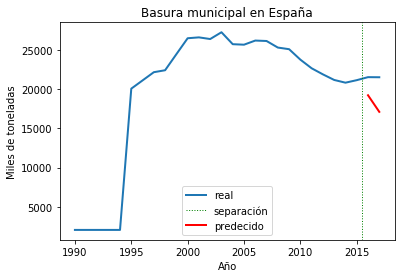

0.37786584278914054


In [22]:
country = 'ESP'
esp = df[df.COU == country]
years = list(esp.Year)
mun = list(esp.Municipal)
predictions = clf1.predict(pd.DataFrame(scalerX.transform(df.loc[esp.index[Year_to_separate-2017::],:][[
       'Built', 'Below Secundary', 'Income Median',
       'Population', 'Over 65', 'Over 65 Percentage', 'Over 85',
       'Over 85 Percentage', 'Over 50', 'Over 50 Percentage', 'Under 20',
       'Under 20 Percentage', 'Income Per Capita', 'Tourism', 'Area',
       'Built Area']])))
predictions = [a[0] for a in scalerY.inverse_transform([[a,0] for a in predictions])]
plt.plot(years, mun, lw=2, label='real')
plt.axvline(x=Year_to_separate + 0.5, c='green', lw=1, ls=':', label='separación')
plt.plot([y for y in years if y > Year_to_separate], predictions, c='red', lw=2, label='predecido')
plt.title("Basura municipal en España")
plt.xlabel("Año")
plt.ylabel("Miles de toneladas")
plt.legend()
plt.show()
print(np.abs(((np.array(mun[-len(predictions):]) - np.array(predictions)))/np.array(predictions)).sum())
deu2015 = predictions

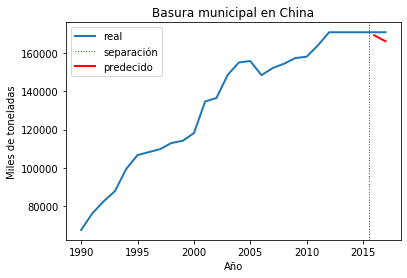

0.03786559580472454


In [23]:
country = 'CHN'
esp = df[df.COU == country]
years = list(esp.Year)
mun = list(esp.Municipal)
predictions = clf1.predict(pd.DataFrame(scalerX.transform(df.loc[esp.index[Year_to_separate-2017::],:][[
       'Built', 'Below Secundary', 'Income Median',
       'Population', 'Over 65', 'Over 65 Percentage', 'Over 85',
       'Over 85 Percentage', 'Over 50', 'Over 50 Percentage', 'Under 20',
       'Under 20 Percentage', 'Income Per Capita', 'Tourism', 'Area',
       'Built Area']])))
predictions = [a[0] for a in scalerY.inverse_transform([[a,0] for a in predictions])]
plt.plot(years, mun, lw=2, label='real')
plt.axvline(x=Year_to_separate + 0.5, c='green', lw=1, ls=':', label='separación')
plt.plot([y for y in years if y > Year_to_separate], predictions, c='red', lw=2, label='predecido')
plt.title("Basura municipal en China")
plt.xlabel("Año")
plt.ylabel("Miles de toneladas")
plt.legend()
plt.show()
print(np.abs(((np.array(mun[-len(predictions):]) - np.array(predictions)))/np.array(predictions)).sum())
chn2015 = predictions

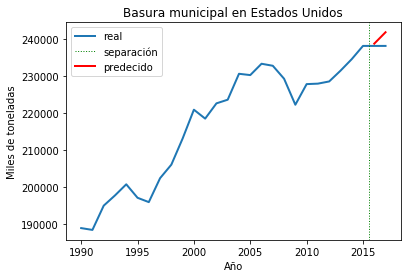

0.017791693618803617


In [24]:
country = 'USA'
esp = df[df.COU == country]
years = list(esp.Year)
mun = list(esp.Municipal)
predictions = clf1.predict(pd.DataFrame(scalerX.transform(df.loc[esp.index[Year_to_separate-2017::],:][[
       'Built', 'Below Secundary', 'Income Median',
       'Population', 'Over 65', 'Over 65 Percentage', 'Over 85',
       'Over 85 Percentage', 'Over 50', 'Over 50 Percentage', 'Under 20',
       'Under 20 Percentage', 'Income Per Capita', 'Tourism', 'Area',
       'Built Area']])))
predictions = [a[0] for a in scalerY.inverse_transform([[a,0] for a in predictions])]
plt.plot(years, mun, lw=2, label='real')
plt.axvline(x=Year_to_separate + 0.5, c='green', lw=1, ls=':', label='separación')
plt.plot([y for y in years if y > Year_to_separate], predictions, c='red', lw=2, label='predecido')
plt.title("Basura municipal en Estados Unidos")
plt.xlabel("Año")
plt.ylabel("Miles de toneladas")
plt.legend()
plt.show()
print(np.abs(((np.array(mun[-len(predictions):]) - np.array(predictions)))/np.array(predictions)).sum())
usa2015 = predictions

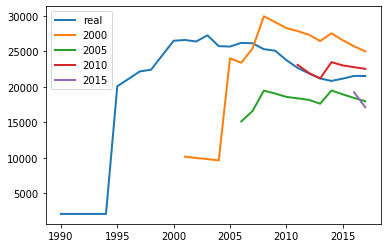

In [25]:
country = 'ESP'
esp = df[df.COU == country]
years = list(esp.Year)
mun = list(esp.Municipal)
plt.plot(years, mun, lw=2, label='real')
plt.plot([y for y in years if y > 2000], deu2000, lw=2, label='2000')
plt.plot([y for y in years if y > 2005], deu2005, lw=2, label='2005')
plt.plot([y for y in years if y > 2010], deu2010, lw=2, label='2010')
plt.plot([y for y in years if y > 2015], deu2015, lw=2, label='2015')
plt.legend()

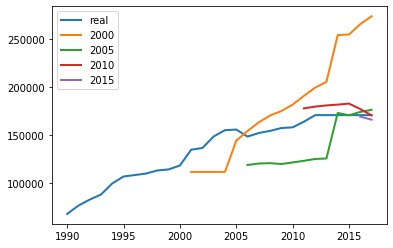

In [26]:
country = 'CHN'
esp = df[df.COU == country]
years = list(esp.Year)
mun = list(esp.Municipal)
plt.plot(years, mun, lw=2, label='real')
plt.plot([y for y in years if y > 2000], chn2000, lw=2, label='2000')
plt.plot([y for y in years if y > 2005], chn2005, lw=2, label='2005')
plt.plot([y for y in years if y > 2010], chn2010, lw=2, label='2010')
plt.plot([y for y in years if y > 2015], chn2015, lw=2, label='2015')
plt.legend()

Text(0, 0.5, 'Miles de toneladas')

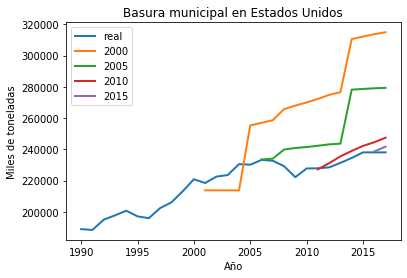

In [28]:
country = 'USA'
esp = df[df.COU == country]
years = list(esp.Year)
mun = list(esp.Municipal)
plt.plot(years, mun, lw=2, label='real')
plt.plot([y for y in years if y > 2000], usa2000, lw=2, label='2000')
plt.plot([y for y in years if y > 2005], usa2005, lw=2, label='2005')
plt.plot([y for y in years if y > 2010], usa2010, lw=2, label='2010')
plt.plot([y for y in years if y > 2015], usa2015, lw=2, label='2015')
plt.legend()
plt.title("Basura municipal en Estados Unidos")
plt.xlabel("Año")
plt.ylabel("Miles de toneladas")